In [88]:
import itertools
import numpy as np
import qiskit
from qiskit import QuantumCircuit,QuantumRegister, circuit, converters
from qiskit.circuit.library.standard_gates import XGate
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.bit import *

# Grover's algorithm applied to a satisfiability problem
 
 The 3-SAT problem is a well known NP-complete problem. It consists in looking for vectors : $$(x_0, . . . , x_{n-1}) \in \{0, 1\}^n$$
satisfying a given predicate f in the form of a conjunction of clauses
which are all 3-disjunctions.

### answer 0 :

We condider the the predicate f defined as : 
$$f(x_0,x_1,x_2,x_3,x_4) = (\overline{x_0}\cup x_1)\cap(x_0\cup x_1 \cup \overline{x_2})\cap(x_2\cup x_3)\cap(\overline{x_1}\cup\overline{x_2}\cup x_3)\cap(\overline{x_3}\cup \overline{x_4})\cap(\overline{x_2}\cup \overline{x_3}\cup x_4)$$
There are 3 possible solutions :
$$v_1 = (0, 0, 0, 1, 0)\qquad v_2 = (0, 1, 0, 1, 0) \qquad v_3 = (1, 1, 0, 1, 0)$$

We get this through this code:

In [2]:
def compute(n, expr):
    combinations = list(itertools.product([0, 1], repeat=n))
    
    matrix = np.array(combinations)
    res = [expr(x) for x in matrix]
    print([matrix[x] for x in range(np.power(2,n)) if res[x] == True])

In [3]:
def custom_expression(x):
    return (
        (not x[0] or x[1]) and
        (x[0] or x[1] or not x[2]) and
        (x[2] or x[3]) and
        (not x[1] or not x[2] or x[3]) and
        (not x[3] or not x[4]) and
        (not x[2] or not x[3] or x[4])
    )
compute(5, custom_expression)

[array([0, 0, 0, 1, 0]), array([0, 1, 0, 1, 0]), array([1, 1, 0, 1, 0])]


### answer 1 :

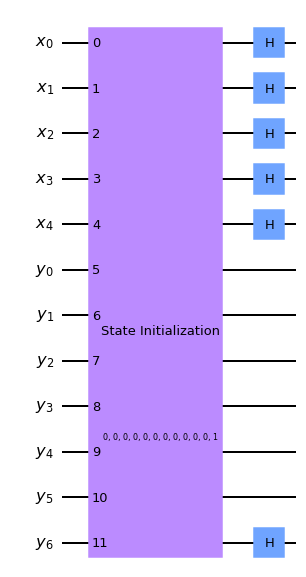

In [56]:
f_in = QuantumRegister(5, name='x')
y = QuantumRegister(7, name='y')

state_prep = QuantumCircuit(f_in, y)
state_prep.prepare_state('000000000001', state_prep.qubits, label='State Initialization')

for i in range(5):
    state_prep.h(i)
    
state_prep.h(11)
state_prep.draw('mpl')

### answer 2 :

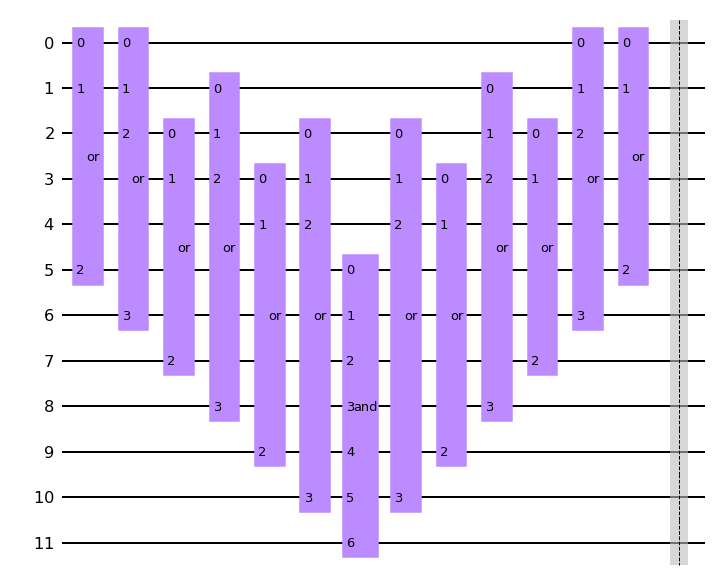

In [57]:
oracle_gate = QuantumCircuit(state_prep.qubits)

clause_1 = circuit.library.OR(2, [-1,1])
clause_2 = circuit.library.OR(3, [1,1,-1])
clause_3 = circuit.library.OR(2, [1,1])
clause_4 = circuit.library.OR(3, [-1,-1,1])
clause_5 = circuit.library.OR(2, [-1,-1])
clause_6 = circuit.library.OR(3, [-1,-1,1])
and_grouping = circuit.library.AND(6, [1,1,1,1,1,1])

qubits = np.array(oracle_gate.qubits)

oracle_gate = oracle_gate.compose(clause_1, qubits=qubits.take([0,1,5]))
oracle_gate = oracle_gate.compose(clause_2, qubits=qubits.take([0,1,2,6]))
oracle_gate = oracle_gate.compose(clause_3, qubits=qubits.take([2,3,7]))
oracle_gate = oracle_gate.compose(clause_4, qubits=qubits.take([1,2,3,8]))
oracle_gate = oracle_gate.compose(clause_5, qubits=qubits.take([3,4,9]))
oracle_gate = oracle_gate.compose(clause_6, qubits=qubits.take([2,3,4,10]))

oracle_gate = oracle_gate.compose(and_grouping, qubits=qubits[5:12])

oracle_gate = oracle_gate.compose(clause_6, qubits=qubits.take([2,3,4,10]))
oracle_gate = oracle_gate.compose(clause_5, qubits=qubits.take([3,4,9]))
oracle_gate = oracle_gate.compose(clause_4, qubits=qubits.take([1,2,3,8]))
oracle_gate = oracle_gate.compose(clause_3, qubits=qubits.take([2,3,7]))
oracle_gate = oracle_gate.compose(clause_2, qubits=qubits.take([0,1,2,6]))
oracle_gate = oracle_gate.compose(clause_1, qubits=qubits.take([0,1,5]))

oracle_gate.barrier()
oracle_gate.draw('mpl')

### answer 3 :

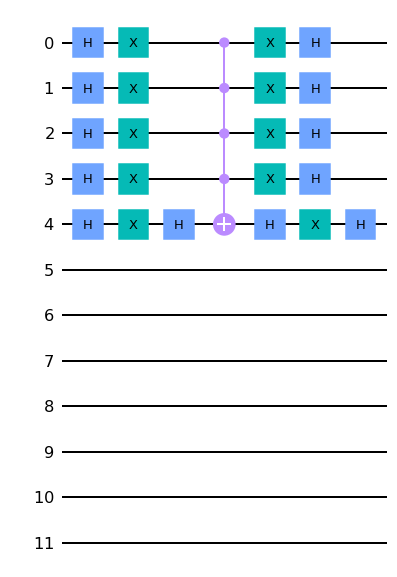

In [58]:
reflection_gate = QuantumCircuit(state_prep.qubits)

for i in range(5):
    reflection_gate.h(i)
    reflection_gate.x(i)
    
reflection_gate.h(4)
c3h_gate = XGate().control(4)
reflection_gate.append(c3h_gate, state_prep.qubits[:5] )
reflection_gate.h(4)

for i in range(5):
    reflection_gate.x(i)
    reflection_gate.h(i)
    
reflection_gate.draw('mpl')

### answer 4 :

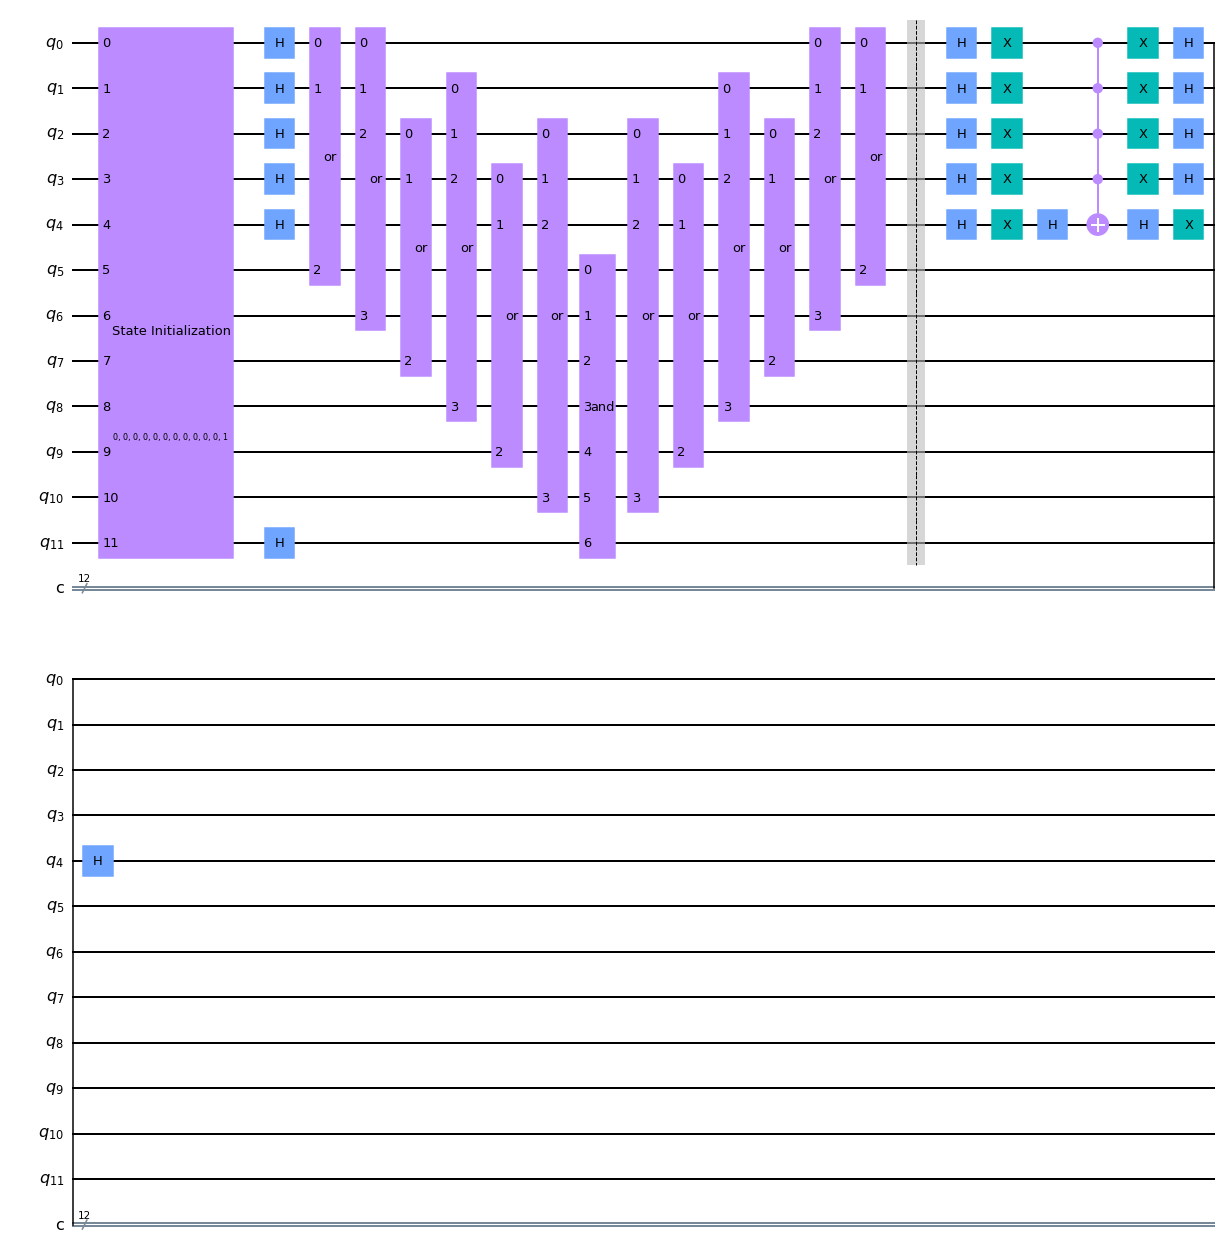

In [139]:
full_circuit = QuantumCircuit(len(state_prep.qubits), len(state_prep.qubits))

full_circuit = full_circuit.compose(state_prep).compose(oracle_gate).compose(reflection_gate)

full_circuit.draw('mpl')

In [162]:
sim_ideal = AerSimulator()  # construct simulator

K = 50

circuits = []
circuits.append(full_circuit)

for k in range(1,K):
    circuits.append(circuits[-1].compose(oracle_gate.compose(reflection_gate)))

circuits[0].draw('mpl')

for circ in circuits:
    circ = circ.measure(full_circuit.qubits[:5], full_circuit.clbits[:5])
#circuits = [circ.measure(full_circuit.qubits[:5], full_circuit.clbits[:5]) for circ in circuits ]



In [ ]:
counts = np.empty(K,dtype=object)
for i in range(K):
    job_ideal = sim_ideal.run(transpile(circuits[i], sim_ideal), shots=100)  # launch a job to run the circuit multiple times
    res_ideal = job_ideal.result()  # obtain results of a run
    counts[i] = res_ideal.get_counts()  # obtain results of the measumerents

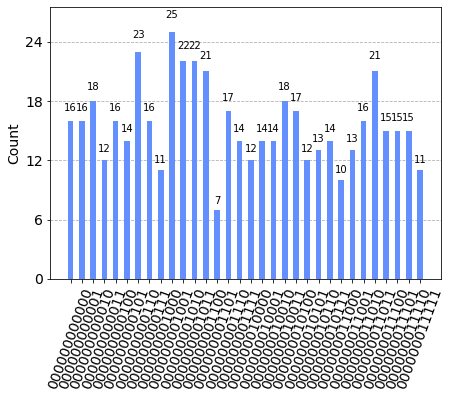

In [161]:
plot_histogram(counts[14])

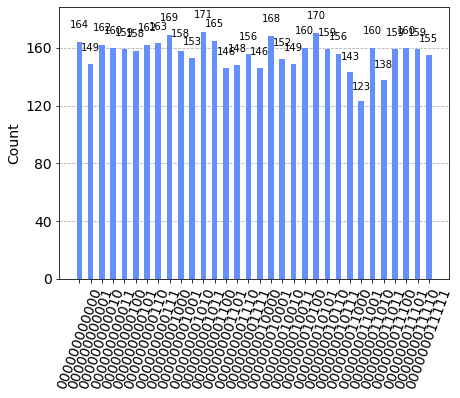

In [155]:
plot_histogram(counts[1])

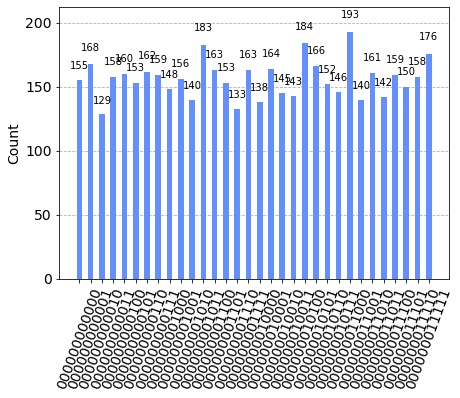

In [156]:
plot_histogram(counts[2])

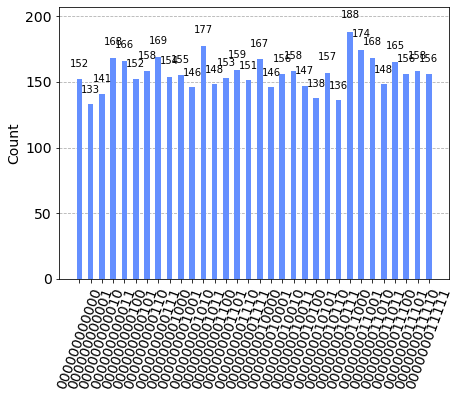

In [157]:
plot_histogram(counts[3])

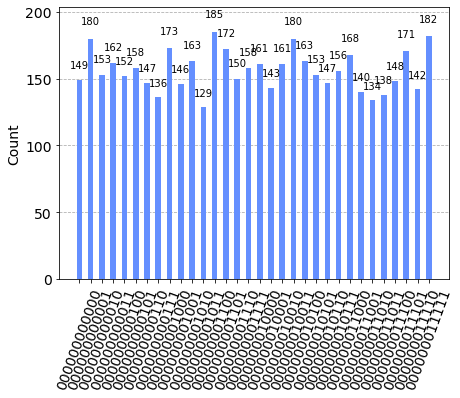

In [158]:
plot_histogram(counts[4])